# Семинар № 6 - VAE (ч1)

# Imports 

In [4]:
# !pip install -q -U albumentations
!pip install --upgrade -q albumentations==0.4.6
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 117 kB 5.4 MB/s 
     |████████████████████████████████| 948 kB 38.6 MB/s 
albumentations==0.4.6 is successfully installed


In [1]:
import os
from pathlib import Path
import random
import typing as tp
from time import gmtime, strftime

import yaml
from tqdm import tqdm
from cv2 import erode
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import rotate, rescale, resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
set_seed(42)

DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# DEVICE = torch.device('cpu')

In [4]:
DEVICE

device(type='cuda', index=0)

# Набор данных


In [5]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_validset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
len(mnist_trainset), len(mnist_validset)

(60000, 10000)

In [7]:
img, label = mnist_trainset[8]

In [8]:
label

1

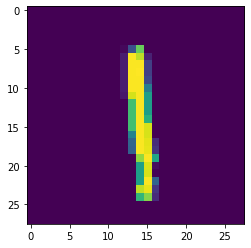

In [9]:
plt.imshow(np.array(img))

## Create dataset

In [10]:
class MNISTDataset(Dataset):
    def __init__(self, data,
                 transforms: tp.Optional[A.BasicTransform] = None):
        self.data = data
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> dict:
        image, label = self.data[idx]
        image = np.array(image)
        
        # check for dimensions            
        if image.ndim == 2:
            image = image[..., np.newaxis]
            
        result = {"image": image}

        if self.transforms is not None:
            result = self.transforms(**result)
            
        image = result['image']
        label = torch.tensor(label).long()

        return image, label

## Create augs

In [11]:
img, _ = mnist_trainset[1]
type(np.array(img))

numpy.ndarray

In [12]:
def pre_transform() -> A.BasicTransform:
    result = []
    return A.Compose(result)


def augmentations() -> A.BasicTransform:
    result = [
        # A.GaussNoise(),
    ]
    return A.Compose(result)


def post_transform() -> A.BasicTransform:
    return A.Compose([
        A.Normalize(mean=0, 
                    std=1,
                    max_pixel_value=255),
        ToTensorV2()
    ])

In [13]:
# Create train pipeline
train_transformation = A.Compose([
    pre_transform(), augmentations(), post_transform()
])


# Create valid pipeline
valid_transformation = A.Compose([
    pre_transform(), post_transform()
])  

### Check augs

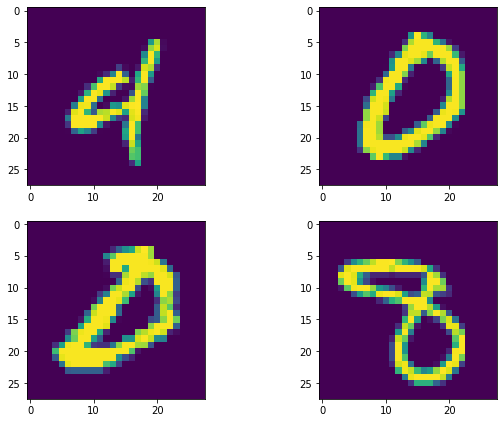

In [14]:
_, ax = plt.subplots(2, 2, figsize=(6.4 * 1.5, 4.8 * 1.5))

for i in range(4):
    sample_idx = np.random.randint(0, len(mnist_trainset), 1)[0]
    sample_image, _ = mnist_trainset[sample_idx]
    sample_image = np.array(sample_image)[..., np.newaxis]
    aug_image = train_transformation(image=sample_image)["image"].numpy()
    ax[i % 2][i // 2].imshow(aug_image[0])
    
plt.show()

## Make DataLoader 

In [15]:
batch_size = 128
num_workers = 4  # num_workers = 0 for local notebook on win 

train_dataset = MNISTDataset(mnist_trainset, train_transformation)
train_loader = DataLoader(
    train_dataset, 
    shuffle=True,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

valid_dataset = MNISTDataset(mnist_validset, valid_transformation) 
valid_loader = DataLoader(
    valid_dataset, 
    shuffle=False,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=True,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
image, label = next(iter(train_loader))

print('Image batch shape:', image.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Image batch shape: torch.Size([128, 1, 28, 28])


# Create model 

In [17]:
class Encoder(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()
        self.latent_size = latent_size

        # Create CNN encoder model
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28 -> 14
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 -> 7
            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.fc_mean = nn.Linear(64, latent_size)
        self.fc_var = nn.Linear(64, latent_size)
        
    def forward(self, images: torch.Tensor):
        features = self.feature_extractor(images)
        mean = self.fc_mean(features)
        log_var = self.fc_var(features)

        return mean, log_var

In [18]:
x = torch.rand(12, 1, 28, 28)
encoder = Encoder()

In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()
        self.latent_size = latent_size

        # Create Decoder model!
        self.map_generator = nn.Sequential(
            nn.Linear(latent_size, 10 * 49),  # out: 10 x 7 x 7
        )
        # create up-sample layers
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(10, 10, kernel_size=(3, 3), stride=2, padding=1, output_padding=1), # 7 -> 14
            nn.ReLU(),
            nn.ConvTranspose2d(10, 3, kernel_size=(3, 3), stride=2, padding=1, output_padding=1), # 14 -> 28
            nn.ReLU(),
        )
        # create final conv layer
        self.output = nn.Sequential(
            nn.Conv2d(3, 1, 3, padding=1),
            nn.Tanh()
        )
            
    def forward(self, points: torch.Tensor) -> torch.Tensor:
        feature_map = self.map_generator(points)

        # bs, ch -> bs, ch, h, w
        feature_map = feature_map.reshape(feature_map.size(0), -1, 7, 7) 
        feature_map = self.deconv(feature_map)
        
        return self.output(feature_map)

In [20]:
x = torch.rand(12, 2)
decoder = Decoder(2)

out = decoder(x)
out.shape

torch.Size([12, 1, 28, 28])

In [21]:
LOG_SCALE_MAX = 2
LOG_SCALE_MIN = -10

def normal_sample(loc: torch.Tensor, log_scale: torch.Tensor) -> torch.Tensor:
    scale = torch.exp(0.5 * log_scale)
    return loc + scale * torch.randn_like(scale)


class VAE(nn.Module):
    def __init__(self, latent_size: int = 2):
        super().__init__()

        self.encoder = Encoder(latent_size)
        self.decoder = Decoder(latent_size)
        
    def forward(self, x: torch.Tensor):
        mean, log_var = self.encoder(x)  # get mean and log_var for sampling
        log_var = torch.clamp(log_var, LOG_SCALE_MIN, LOG_SCALE_MAX)

        z_ = normal_sample(mean, log_var) if self.training else mean
        x_ = self.decoder(z_)  # recreate object from z_

        return x_, mean, log_var

In [22]:
latent_size = 16
model = VAE(latent_size).to(DEVICE)

In [23]:
x = torch.ones((256, 1, 28, 28)).to(DEVICE)

x_hat, mean, log_var = model(x)

In [24]:
x_hat.shape, mean.shape, log_var.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256, 16]), torch.Size([256, 16]))

## Define loss

In [25]:
BCE_loss = nn.BCELoss()

def KLD_loss(mean, log_var):
     return (-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1)).mean()

In [26]:
KLD_loss(mean, log_var)

tensor(0.0963, device='cuda:0', grad_fn=<MeanBackward0>)

In [27]:
BCE_loss(x_hat.sigmoid(), x)

tensor(0.7824, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [47]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)

## Train loop

In [48]:
epochs = 20

In [49]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (x, _) in pbar:
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss_bce = BCE_loss(x_hat.sigmoid(), x)
        loss_kld = KLD_loss(mean, log_var)
        loss = loss_bce + loss_kld
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()

        log_line = f'Loss: {loss.detach().cpu().data:.4f}'
        pbar.set_description(log_line)

        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx * batch_size))
    
print("Finish!!")

Start training VAE...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss: 0.4371: 100%|██████████| 468/468 [00:17<00:00, 27.02it/s]


	Epoch 1 complete! 	Average Loss:  0.003405855132996781


Loss: 0.4350: 100%|██████████| 468/468 [00:17<00:00, 26.23it/s]

	Epoch 2 complete! 	Average Loss:  0.003395957260031644



Loss: 0.4307: 100%|██████████| 468/468 [00:17<00:00, 27.01it/s]

	Epoch 3 complete! 	Average Loss:  0.003395366504872158



Loss: 0.4319: 100%|██████████| 468/468 [00:18<00:00, 24.67it/s]

	Epoch 4 complete! 	Average Loss:  0.003395058574131042



Loss: 0.4362: 100%|██████████| 468/468 [00:17<00:00, 26.77it/s]

	Epoch 5 complete! 	Average Loss:  0.0033947908248736403



Loss: 0.4329: 100%|██████████| 468/468 [00:17<00:00, 26.85it/s]

	Epoch 6 complete! 	Average Loss:  0.0033946606087273015



Loss: 0.4350: 100%|██████████| 468/468 [00:17<00:00, 26.68it/s]

	Epoch 7 complete! 	Average Loss:  0.003394648294130089



Loss: 0.4367: 100%|██████████| 468/468 [00:17<00:00, 26.53it/s]


	Epoch 8 complete! 	Average Loss:  0.003394400816095686


Loss: 0.4322: 100%|██████████| 468/468 [00:17<00:00, 26.48it/s]

	Epoch 9 complete! 	Average Loss:  0.0033943210229899824



Loss: 0.4361: 100%|██████████| 468/468 [00:17<00:00, 26.76it/s]

	Epoch 10 complete! 	Average Loss:  0.0033942512002209206



Loss: 0.4304: 100%|██████████| 468/468 [00:17<00:00, 26.84it/s]

	Epoch 11 complete! 	Average Loss:  0.003394189670111593



Loss: 0.4311: 100%|██████████| 468/468 [00:17<00:00, 26.50it/s]

	Epoch 12 complete! 	Average Loss:  0.003394158877137195



Loss: 0.4359: 100%|██████████| 468/468 [00:17<00:00, 26.86it/s]

	Epoch 13 complete! 	Average Loss:  0.0033941273682210316



Loss: 0.4280: 100%|██████████| 468/468 [00:17<00:00, 26.82it/s]

	Epoch 14 complete! 	Average Loss:  0.003393957854051151



Loss: 0.4309: 100%|██████████| 468/468 [00:17<00:00, 26.49it/s]

	Epoch 15 complete! 	Average Loss:  0.0033939500454996715



Loss: 0.4347: 100%|██████████| 468/468 [00:17<00:00, 26.57it/s]

	Epoch 16 complete! 	Average Loss:  0.0033938059123627827



Loss: 0.4268: 100%|██████████| 468/468 [00:17<00:00, 26.79it/s]


	Epoch 17 complete! 	Average Loss:  0.0033937478737159766


Loss: 0.4335: 100%|██████████| 468/468 [00:17<00:00, 26.55it/s]

	Epoch 18 complete! 	Average Loss:  0.003393869884950318



Loss: 0.4426: 100%|██████████| 468/468 [00:17<00:00, 26.20it/s]

	Epoch 19 complete! 	Average Loss:  0.0033937527018357908



Loss: 0.4311: 100%|██████████| 468/468 [00:17<00:00, 26.12it/s]

	Epoch 20 complete! 	Average Loss:  0.003393761236300369
Finish!!


In [1]:
!nvidia-smi

Tue Mar 29 16:38:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generate images

In [31]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(valid_loader):
        x = x.to(DEVICE)
        
    
        x_hat, _, _ = model(x)

        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
def show_image(x, idx):

    fig = plt.figure()
    plt.imshow(x[idx][0].cpu().numpy())

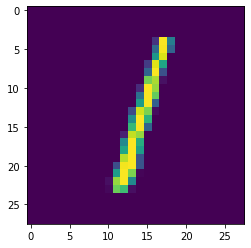

In [33]:
show_image(x, idx=2)

In [50]:
img, _ = mnist_validset[2]
img = np.array(img)[..., np.newaxis]
img = train_transformation(image=img)['image'].float()
img.shape

torch.Size([1, 28, 28])

In [51]:
x_input = img.unsqueeze(0).to(DEVICE)

model.eval()
mean, log_var = model.encoder(x_input)

In [52]:
mean, log_var

(tensor([[ 3.0801e-05,  1.6762e-04, -1.9751e-04,  1.1621e-04,  6.9054e-05,
          -4.6005e-05,  1.4834e-04,  6.1938e-05, -3.0277e-05,  1.8161e-05,
          -3.2287e-06, -1.8279e-05, -6.8021e-05,  2.3109e-04,  7.7539e-05,
          -8.4551e-05]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[ 2.1298e-05, -1.0961e-06,  1.2097e-05,  4.6801e-05, -6.9215e-05,
          -1.0380e-04, -1.8579e-04,  3.5553e-05, -7.2796e-05,  1.1321e-04,
          -1.9089e-04, -5.9192e-05,  4.4707e-05,  1.1660e-04, -1.7187e-05,
          -8.9475e-05]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [55]:
out = model.decoder(mean)

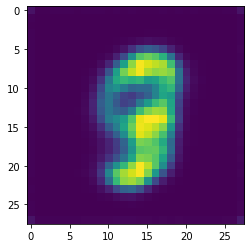

In [56]:
show_image(out.detach(), 0)

In [59]:
model.eval()

x = torch.rand(12, latent_size) * 1e-6 + 1
out = model.decoder(x.to(DEVICE))
out.shape

torch.Size([12, 1, 28, 28])

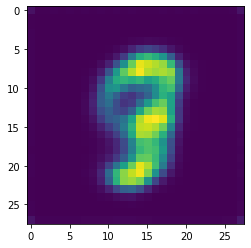

In [60]:
show_image(out.detach(), 7)